# Music genre prediction

## Вводная информация

### Описание задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Этапы работы

* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

### Данные

* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение * 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

### Описание полей данных

* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность 
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - тональность
* liveness - привлекательность
* loudness - громкость
* mode - наклонение
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Предподготовка данных

### Загрузка и изучение данных

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, accuracy_score, classification_report)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler

from catboost import CatBoostClassifier
from sklearn.utils import resample, shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from sklearn.experimental import enable_iterative_imputer  # Enable IterativeImputer
from sklearn.impute import IterativeImputer
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.combine import SMOTETomek

In [42]:
train = pd.read_csv('kaggle_music_genre_train.csv')

In [43]:
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [45]:
train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [46]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,20394.0,55973.846916,20695.792545,20011.00000,38157.25000,56030.000000,73912.750000,91758.000
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


In [47]:
train = train.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [48]:
# проверим есть ли дубликаты в тренировочном и тестовом датасетах
train.duplicated().sum()

7

In [49]:
train = train.drop_duplicates()

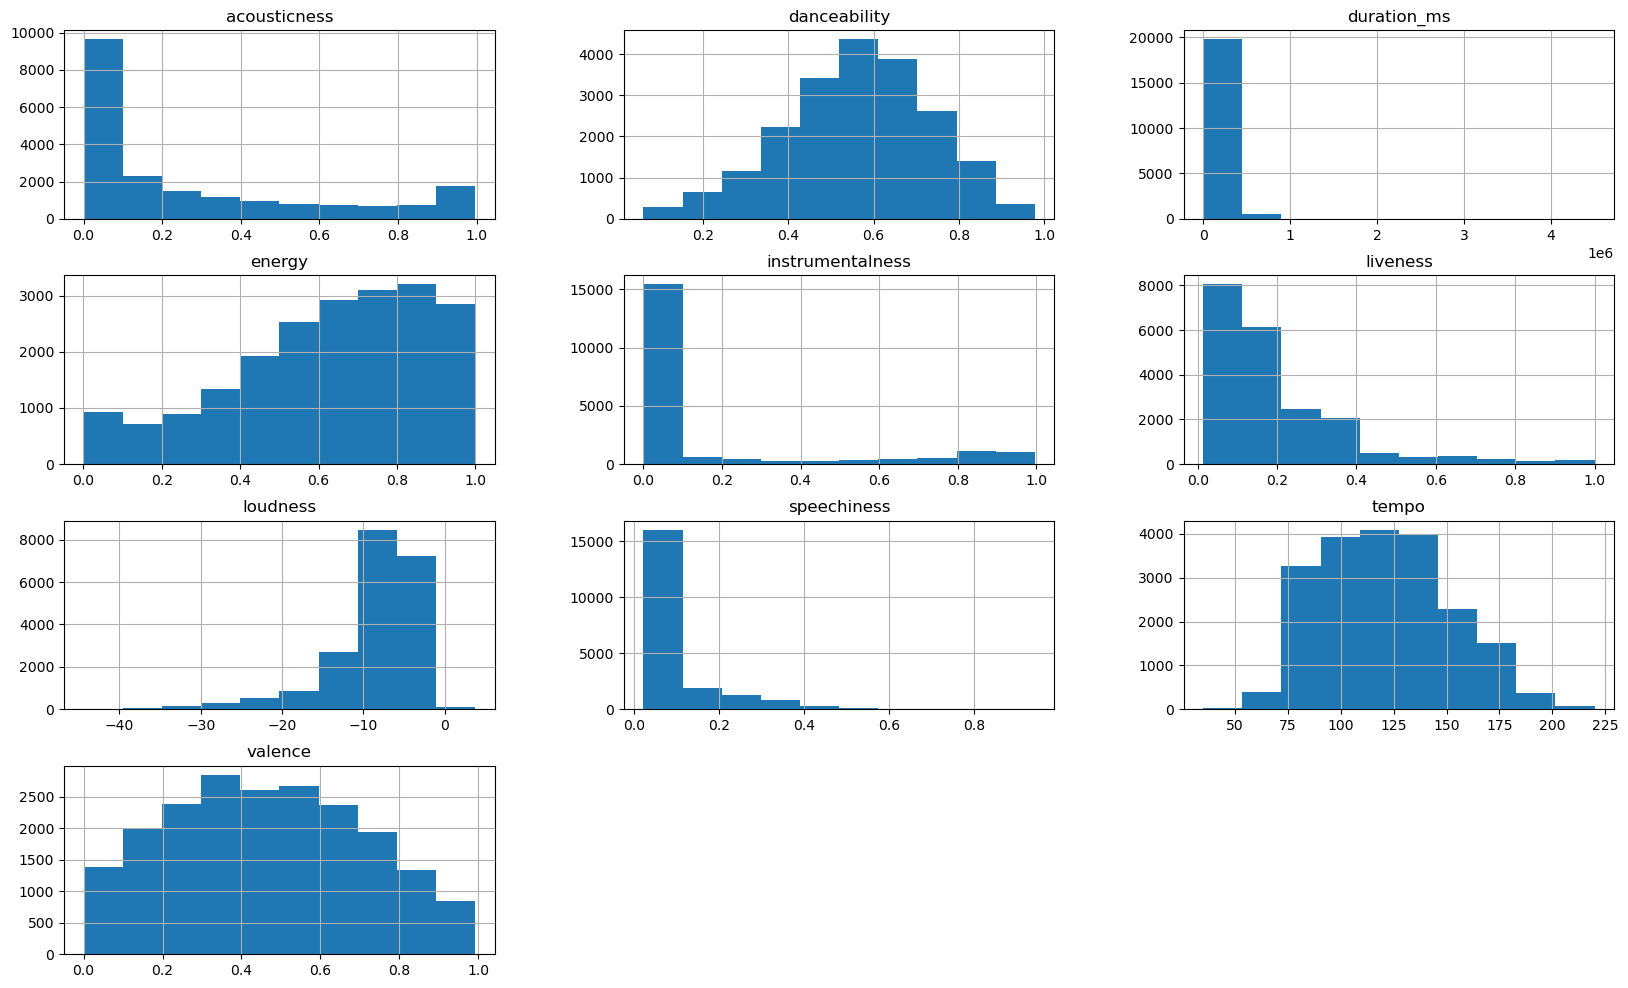

In [50]:
# построим гистограммы распределения тренировочного датасета
train.hist(figsize=(20, 12));

In [51]:
phik_overview = train.phik_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


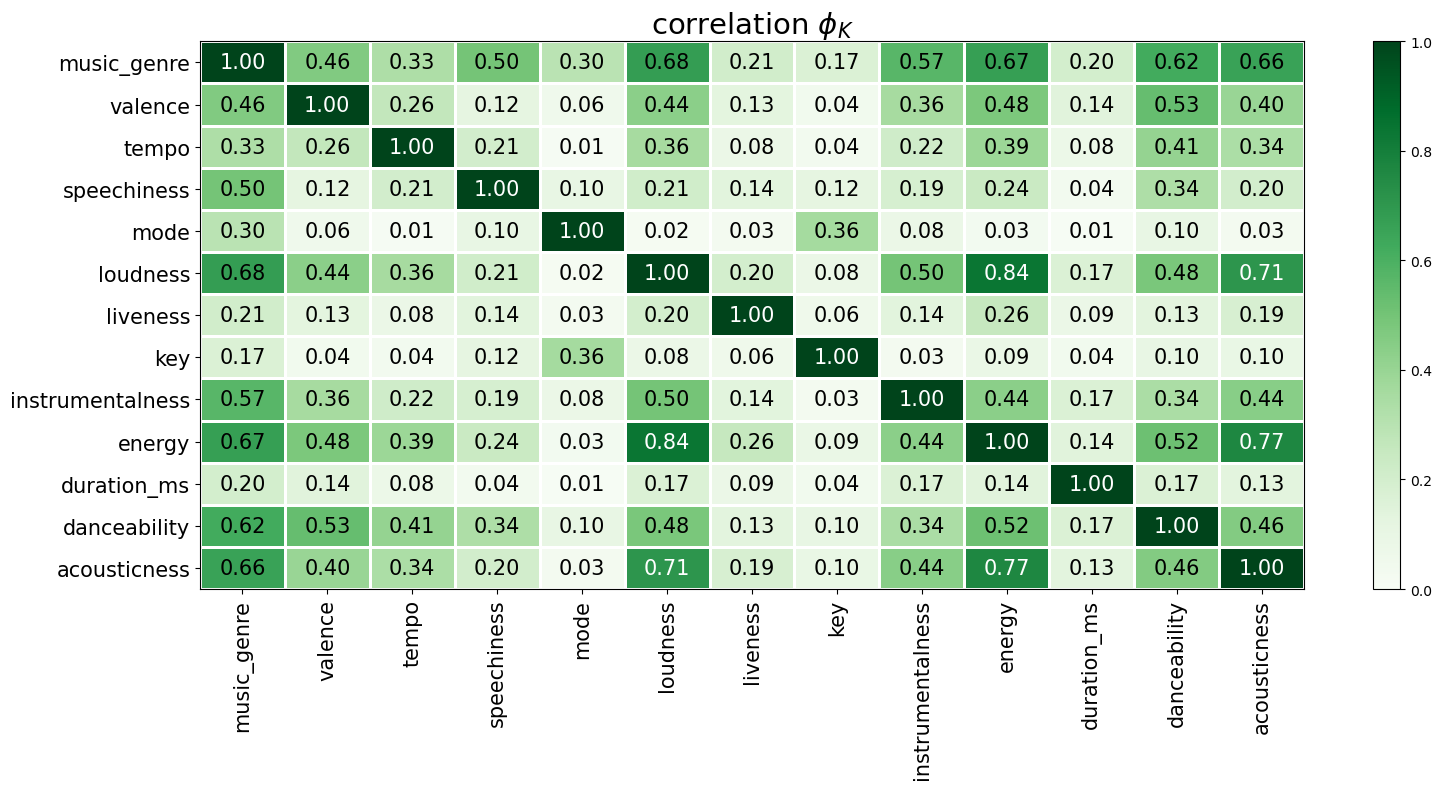

In [52]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

In [53]:
significance_overview = train.significance_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


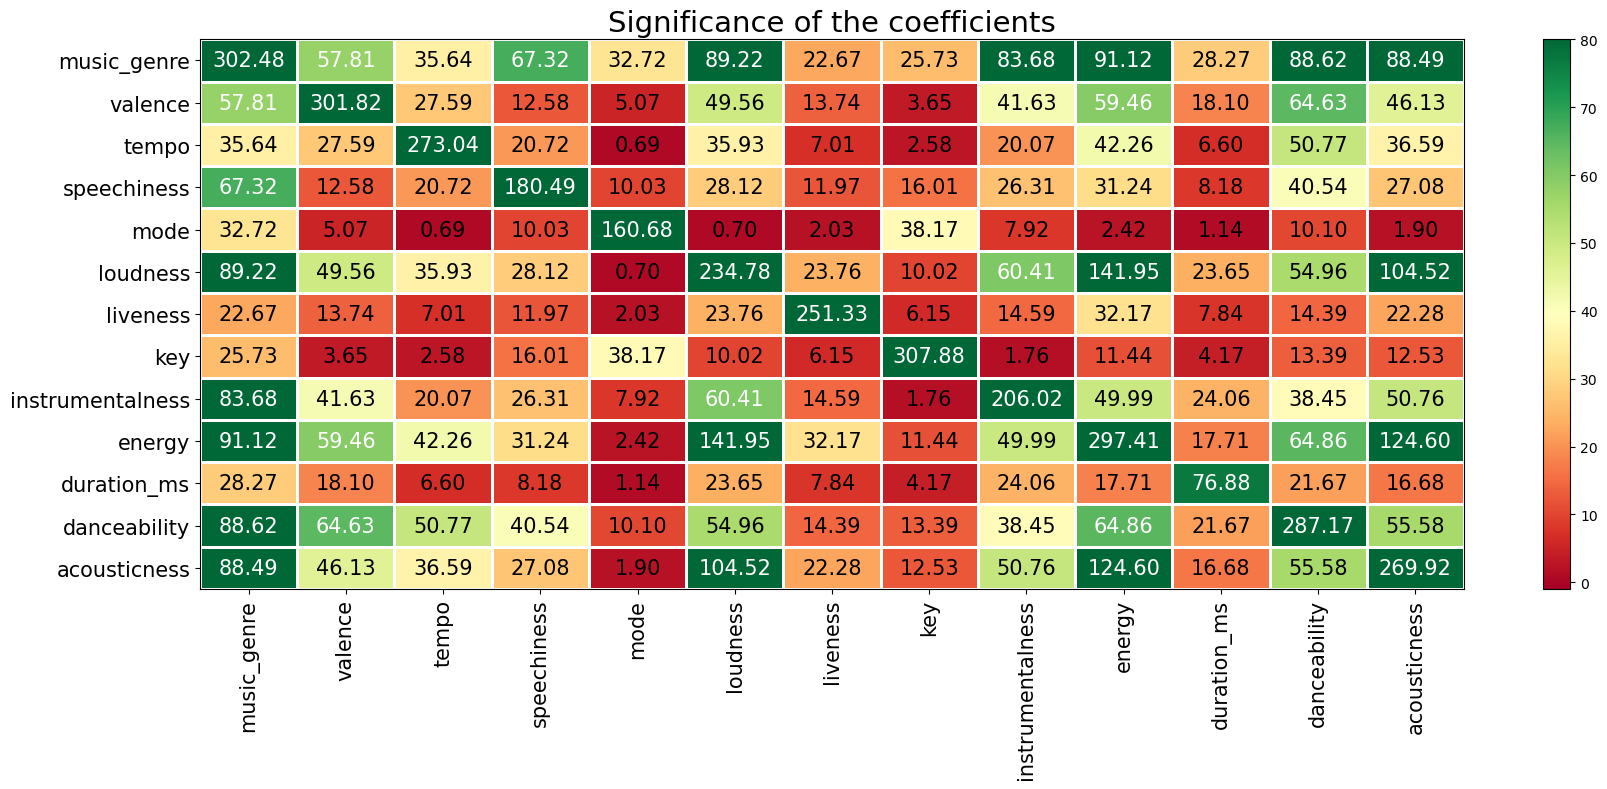

In [54]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-1, vmax=80, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 8))
plt.tight_layout()

In [55]:
global_correlation, global_labels = train.global_phik() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


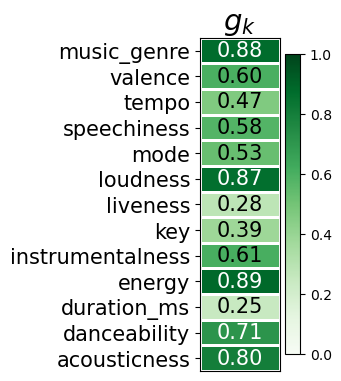

In [56]:
plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

In [57]:
# train['combined_feature'] = (train['energy'] + train['loudness'] + train['acousticness']) / 3
# train = train.drop(['energy', 'loudness', 'acousticness'], axis=1)

Разработка новых синтетических признаков приводит к снижению f1-меры на 0.01 - 0.02 единицы. Поэтому в дальнейшем будем использовать только исходные признаки.

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20387 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20387 non-null  float64
 1   danceability      20387 non-null  float64
 2   duration_ms       20387 non-null  float64
 3   energy            20387 non-null  float64
 4   instrumentalness  20387 non-null  float64
 5   key               19653 non-null  object 
 6   liveness          20387 non-null  float64
 7   loudness          20387 non-null  float64
 8   mode              19881 non-null  object 
 9   speechiness       20387 non-null  float64
 10  tempo             19945 non-null  float64
 11  valence           20387 non-null  float64
 12  music_genre       20387 non-null  object 
dtypes: float64(10), object(3)
memory usage: 2.2+ MB


In [59]:
train.isna().sum()

acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 734
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
valence               0
music_genre           0
dtype: int64

In [60]:
train['key'].value_counts() 

G     2303
C     2149
C#    2125
D     2109
A     2013
F     1615
B     1521
E     1516
G#    1267
A#    1223
F#    1206
D#     606
Name: key, dtype: int64

In [61]:
train['mode'].value_counts() 

Major    12826
Minor     7055
Name: mode, dtype: int64

In [62]:
train['music_genre'].value_counts() 

Blues          2857
Alternative    2601
Electronic     2559
Rap            2427
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

## Подготовка данных к обучению моделей

### Тестируем pipeline

In [63]:
X = train.drop('music_genre', axis=1)
y = train['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [64]:
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [65]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16309, 12), (4078, 12), (16309,), (4078,))

In [66]:
num_pipeline = Pipeline(steps=[
    ('impute', IterativeImputer(max_iter=10, random_state=42)),
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('PolynomialFeatures', PolynomialFeatures(degree=2)),
    ('DropConstantFeatures', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


In [67]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

### GridSearchCV

In [68]:
'''%%time
clf = LogisticRegression()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

param_dist = {
    'model__C': np.logspace(-3, 3, 7),  # Логарифмический диапазон для параметра C
    'model__penalty': ['l1', 'l2'],  # Регуляризация l1 или l2
    'model__solver': ['liblinear', 'saga']  # Различные методы оптимизации для l1 регуляризации
}

grid_pipeline = RandomizedSearchCV(clf_pipeline, param_distributions=param_dist, n_iter=10, scoring='f1_weighted', cv=5, verbose=1, n_jobs=-1)

grid_pipeline.fit(X_train, y_train)

preds = grid_pipeline.predict(X_test)
f1 = f1_score(y_test, preds, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)'''

'%%time\nclf = LogisticRegression()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparam_dist = {\n    \'model__C\': np.logspace(-3, 3, 7),  # Логарифмический диапазон для параметра C\n    \'model__penalty\': [\'l1\', \'l2\'],  # Регуляризация l1 или l2\n    \'model__solver\': [\'liblinear\', \'saga\']  # Различные методы оптимизации для l1 регуляризации\n}\n\ngrid_pipeline = RandomizedSearchCV(clf_pipeline, param_distributions=param_dist, n_iter=10, scoring=\'f1_weighted\', cv=5, verbose=1, n_jobs=-1)\n\ngrid_pipeline.fit(X_train, y_train)\n\npreds = grid_pipeline.predict(X_test)\nf1 = f1_score(y_test, preds, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

In [69]:
"""%%time

clf = SVC()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__C': [0.1, 1, 10],
'model__kernel': ['linear', 'rbf', 'poly']}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
y_pred = grid_pipeline.predict(X_test)

# Вычисление F1-меры
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")

# Вывод наилучших параметров и оценки
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)"""

'%%time\n\nclf = SVC()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__C\': [0.1, 1, 10],\n\'model__kernel\': [\'linear\', \'rbf\', \'poly\']}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\n\n# Получение предсказаний на тестовом наборе данных\ny_pred = grid_pipeline.predict(X_test)\n\n# Вычисление F1-меры\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\n\n# Вывод наилучших параметров и оценки\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

In [70]:
'''%%time

clf = RandomForestClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__n_estimators': [100, 200, 300],
'model__max_depth': [None, 5, 10]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)'''

'%%time\n\nclf = RandomForestClassifier()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__n_estimators\': [100, 200, 300],\n\'model__max_depth\': [None, 5, 10]}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\ny_pred = grid_pipeline.predict(X_test)\n\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

In [71]:
'''%%time

clf = GradientBoostingClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__n_estimators': [100],
'model__max_depth': [3, 5],
'model__learning_rate': [0.1, 0.01]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)'''

'%%time\n\nclf = GradientBoostingClassifier()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__n_estimators\': [100],\n\'model__max_depth\': [3, 5],\n\'model__learning_rate\': [0.1, 0.01]}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\ny_pred = grid_pipeline.predict(X_test)\n\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

In [72]:
'''%%time

clf = MLPClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__hidden_layer_sizes': [(100,), (200,), (300,)],
'model__activation': ['relu', 'tanh', 'logistic'],
'model__alpha': [0.0001, 0.001, 0.01]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)'''

'%%time\n\nclf = MLPClassifier()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__hidden_layer_sizes\': [(100,), (200,), (300,)],\n\'model__activation\': [\'relu\', \'tanh\', \'logistic\'],\n\'model__alpha\': [0.0001, 0.001, 0.01]}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\ny_pred = grid_pipeline.predict(X_test)\n\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

### PipeLine

In [73]:
clf = CatBoostClassifier(depth=4, l2_leaf_reg=1, learning_rate=0.1)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

set_config(display='diagram')
display(clf_pipeline)

0:	learn: 2.2049086	total: 159ms	remaining: 2m 39s
1:	learn: 2.1302392	total: 228ms	remaining: 1m 53s
2:	learn: 2.0752024	total: 291ms	remaining: 1m 36s
3:	learn: 2.0264129	total: 359ms	remaining: 1m 29s
4:	learn: 1.9898761	total: 426ms	remaining: 1m 24s
5:	learn: 1.9551945	total: 482ms	remaining: 1m 19s
6:	learn: 1.9213207	total: 537ms	remaining: 1m 16s
7:	learn: 1.8953733	total: 592ms	remaining: 1m 13s
8:	learn: 1.8661944	total: 650ms	remaining: 1m 11s
9:	learn: 1.8423545	total: 708ms	remaining: 1m 10s
10:	learn: 1.8218084	total: 756ms	remaining: 1m 7s
11:	learn: 1.8000482	total: 800ms	remaining: 1m 5s
12:	learn: 1.7816891	total: 887ms	remaining: 1m 7s
13:	learn: 1.7653361	total: 939ms	remaining: 1m 6s
14:	learn: 1.7508966	total: 995ms	remaining: 1m 5s
15:	learn: 1.7361667	total: 1.05s	remaining: 1m 4s
16:	learn: 1.7260629	total: 1.12s	remaining: 1m 4s
17:	learn: 1.7148455	total: 1.17s	remaining: 1m 4s
18:	learn: 1.7056380	total: 1.24s	remaining: 1m 3s
19:	learn: 1.6962431	total: 1.2

383:	learn: 1.2646037	total: 25.2s	remaining: 40.4s
384:	learn: 1.2639251	total: 25.3s	remaining: 40.4s
385:	learn: 1.2636239	total: 25.3s	remaining: 40.3s
386:	learn: 1.2632078	total: 25.4s	remaining: 40.3s
387:	learn: 1.2628531	total: 25.6s	remaining: 40.3s
388:	learn: 1.2625633	total: 25.7s	remaining: 40.3s
389:	learn: 1.2621957	total: 25.8s	remaining: 40.3s
390:	learn: 1.2618080	total: 25.9s	remaining: 40.3s
391:	learn: 1.2611122	total: 25.9s	remaining: 40.2s
392:	learn: 1.2605858	total: 26.1s	remaining: 40.2s
393:	learn: 1.2600806	total: 26.1s	remaining: 40.2s
394:	learn: 1.2594171	total: 26.3s	remaining: 40.2s
395:	learn: 1.2590003	total: 26.4s	remaining: 40.2s
396:	learn: 1.2583981	total: 26.5s	remaining: 40.2s
397:	learn: 1.2580731	total: 26.5s	remaining: 40.1s
398:	learn: 1.2575125	total: 26.7s	remaining: 40.2s
399:	learn: 1.2571127	total: 26.8s	remaining: 40.2s
400:	learn: 1.2566250	total: 26.9s	remaining: 40.2s
401:	learn: 1.2561868	total: 27s	remaining: 40.2s
402:	learn: 1.

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(random_state=42)),
                                                                  ('scale',
                                                                   RobustScaler()),
                                                                  ('drop_correlated_features',
                                                                   DropCorrelatedFeatures()),
                                                                  ('PolynomialFeatures',
                                                                   PolynomialFeatures()),
                                                                  ('DropConstantFeatures',
                                                                   DropConstantFeatures(tol=0.998))]),
                                                  ['acousticness',
                                                   'dan...ty',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['key', 'mode'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x138850250>)])

Без стратификации при сплите 0.48
Со стратификацией при сплите 0.48

In [74]:
# cross_val_score(clf_pipeline, X, y, scoring='f1_weighted', cv=5).mean()

## Проводим финальное тестирование

In [75]:
test = pd.read_csv('kaggle_music_genre_test.csv')

In [76]:
tes1 = test

In [77]:
test = test.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)
# test['combined_feature'] = (test['energy'] + test['loudness'] + test['acousticness']) / 3
# test = test.drop(['energy', 'loudness', 'acousticness'], axis=1)

In [78]:
y_pred = clf_pipeline.predict(test)

y_pred = y_pred.ravel().tolist()
# Создание столбца с предсказаниями
y_pred_series = pd.Series(y_pred, name='music_genre')

# Создание столбца с instance_id
instance_id_column = tes1['instance_id']

# Создание DataFrame из столбцов
submit = pd.concat([instance_id_column, y_pred_series], axis=1)

# Сохранение DataFrame с предсказаниями в файл
submit.to_csv('submit.csv', index=False)